In [17]:
import numpy as np
import math
import qiskit
import warnings

warnings.filterwarnings("ignore")

from qiskit import (
    QuantumCircuit,
    transpile,
    Aer,
    IBMQ,
    QuantumRegister,
    ClassicalRegister,
)
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer
from qiskit.ignis.verification import state_tomography_circuits
from qiskit.ignis.verification.tomography import (
    state_tomography_circuits,
    StateTomographyFitter,
)


# Loading your IBM Quantum account(s)
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q")
for backend in provider.backends():
    print(backend)

ibmqfactory.load_account:WARNING:2021-06-24 12:47:37,929: Credentials are already in use. The existing account in the session will be replaced.


ibmq_qasm_simulator
ibmqx2
ibmq_16_melbourne
ibmq_armonk
ibmq_athens
ibmq_santiago
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_manila


In [18]:
# Get a real device as backend
real_device = provider.get_backend("ibmq_athens")
real_device

<IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>

# Tomography
Reconstruct density matrix from quantum state tomography

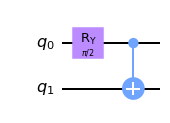

In [19]:
qreg_q = QuantumRegister(2, "q")
# creg_c = ClassicalRegister(1, 'c')
qc = QuantumCircuit(qreg_q)
qc.ry(math.pi / 2, qreg_q[0])
qc.cx(qreg_q[0], qreg_q[1])
qc.draw()

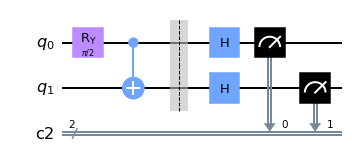

In [20]:
tomography_circuits = state_tomography_circuits(qc, qreg_q)
tomography_circuits[0].draw()

In [22]:
%%time
job = qiskit.execute(tomography_circuits, real_device, shots=8192)
results = job.result()

CPU times: user 333 ms, sys: 202 ms, total: 536 ms
Wall time: 1min 20s


In [25]:
tomo_bell = StateTomographyFitter(results, tomography_circuits)
# Perform the tomography fit
# which outputs a density matrix
rho_mle = tomo_bell.fit(method="lstsq")
np.around(rho_mle, 3)

array([[ 0.506+0.j   ,  0.002-0.017j, -0.001-0.017j,  0.461+0.012j],
       [ 0.002+0.017j,  0.017+0.j   ,  0.001+0.004j, -0.003+0.013j],
       [-0.001+0.017j,  0.001-0.004j,  0.02 +0.j   ,  0.001-0.001j],
       [ 0.461-0.012j, -0.003-0.013j,  0.001+0.001j,  0.457+0.j   ]])

# Fidelity measure  
Measure the fidelity between experimental and theoretical state

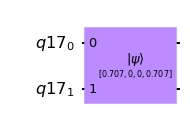

In [26]:
# Bell state: 1/2 * (|00> + |11>)
qc_expected = QuantumCircuit(QuantumRegister(2))
initial_state = [
    math.sqrt(1 / 2),
    0,
    0,
    math.sqrt(1 / 2),
]  # Define initial_state as |1>
qc_expected.initialize(initial_state)
qc_expected.draw()

In [27]:
backend = BasicAer.get_backend("statevector_simulator")
job = qiskit.execute(qc_theory, backend)
expected_state = job.result().get_statevector(qc_theory)
expected_state

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

In [28]:
state_fidelity(expected_state, rho_mle)

0.9426786513270475